In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

In [22]:
heart_df = pd.read_csv('heart.csv')
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [23]:
# Train data wordt gemaakt voor verder gebruik
X_mf = heart_df.drop('target', axis=1)
y_mf = heart_df[['target']]
X_mf.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [24]:
zeroedout = []
for i in range(int(X_mf.size * 0.3)):
    row = random.randint(0, len(X_mf) + 1)
    col = random.choice((X_mf).columns)
    zeroedout.append((row, col))

In [25]:
X_train_mf, X_test_mf, y_train_mf, y_test_mf = train_test_split(X_mf, y_mf, random_state=0, shuffle=True)
rfc = RandomForestClassifier(random_state=0).fit(X_train_mf, y_train_mf)
rfc.score(X_test_mf, y_test_mf)

0.8157894736842105

In [26]:
for i in zeroedout:
    X_mf[i[1]][i[0]] = 0

X_train_mf, X_test_mf, y_train_mf, y_test_mf = train_test_split(X_mf, y_mf, random_state=0, shuffle=True)
rfc = RandomForestClassifier(random_state=0).fit(X_train_mf, y_train_mf)
rfc.score(X_test_mf, y_test_mf)

0.75

In [27]:
for i in zeroedout:
    X_mf[i[1]][i[0]] = X_mf[i[1]].mean()
    
X_train_mf, X_test_mf, y_train_mf, y_test_mf = train_test_split(X_mf, y_mf, random_state=0, shuffle=True)
rfc = RandomForestClassifier(random_state=0).fit(X_train_mf, y_train_mf)
rfc.score(X_test_mf, y_test_mf)

0.7236842105263158

In [28]:
for i in zeroedout:
    X_mf[i[1]][i[0]] = X_mf[i[1]].mode()[0]
    
X_train_mf, X_test_mf, y_train_mf, y_test_mf = train_test_split(X_mf, y_mf, random_state=0, shuffle=True)
rfc = RandomForestClassifier(random_state=0).fit(X_train_mf, y_train_mf)
rfc.score(X_test_mf, y_test_mf)

0.7631578947368421

In [29]:
for i in zeroedout:
    X_mf[i[1]][i[0]] = X_mf[i[1]].median()
    
X_train_mf, X_test_mf, y_train_mf, y_test_mf = train_test_split(X_mf, y_mf, random_state=0, shuffle=True)
rfc = RandomForestClassifier(random_state=0).fit(X_train_mf, y_train_mf)
rfc.score(X_test_mf, y_test_mf)

0.7763157894736842

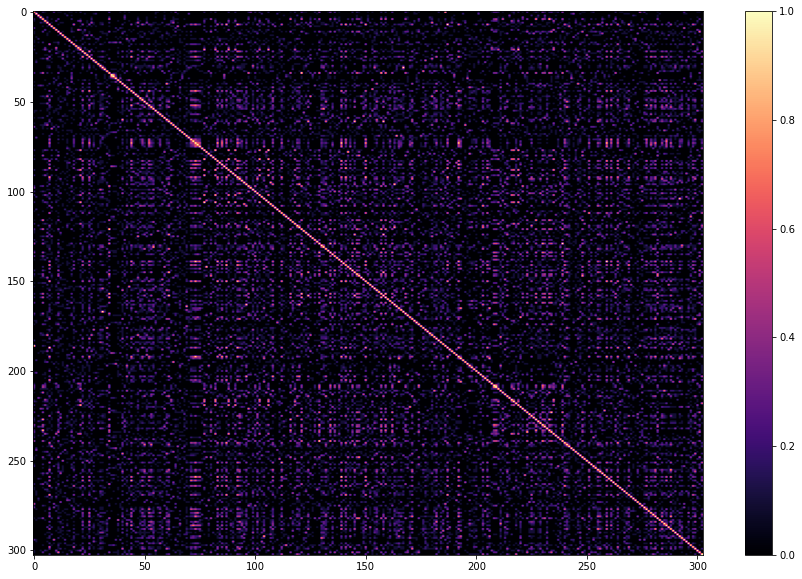

In [30]:
def proximityMatrix(model, X, normalize=True):      

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat

X_train_mf, X_test_mf, y_train_mf, y_test_mf = train_test_split(X_mf, y_mf, random_state=0, shuffle=True)
rfc = RandomForestClassifier(random_state=0).fit(X_train_mf, y_train_mf)
pm = proximityMatrix(rfc, pd.concat([X_train_mf, X_test_mf]))

plt.figure(figsize=[15,10])
plt.imshow(pm, aspect='auto', cmap='magma')
plt.colorbar()